<a href="https://colab.research.google.com/github/Larraguibel/DNN_neuroscience/blob/main/blurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importaciones

In [1]:
!pip install --upgrade torch torchvision

In [2]:
cuda = True
train_batch_size = 32
test_batch_size = 124
best_loss = float("inf")
best_epoch = -1
dataset_path = './cifar10'
gsync_save = True

In [3]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np

In [4]:
try:
    import torch
except ModuleNotFoundError:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


try:
    import torchvision
except ModuleNotFoundError:
    !pip install -q torchvision

from torchvision import datasets, transforms


if gsync_save:
    try:
        import utils
    except ModuleNotFoundError:
        !wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
        import utils

try:
    from allconv import AllConvNet
except ModuleNotFoundError:
    !wget https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
    from allconv import AllConvNet

## 2. Transformacion y carga de datos

In [5]:
# Damos acceso a google drive para guardar modelos

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
class NormalizeNegativeImages(object):

    def __call__(self, item):
        min_value_pixel = torch.min(item)
        if min_value_pixel < 0:
            item -= min_value_pixel
            item /= torch.max(item)
        return item

In [7]:
# Semilla para estandarizar resultados
torch.manual_seed(2320)

cuda = cuda and torch.cuda.is_available()

trainset = datasets.CIFAR10(root=dataset_path, train=True, download=True)
train_mean = trainset.data.mean(axis=(0, 1, 2)) / 255
train_std = trainset.data.std(axis=(0, 1, 2)) / 255

transform_train = transforms.Compose([
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(train_mean, train_std),
     NormalizeNegativeImages()
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages()
])

Files already downloaded and verified


In [8]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


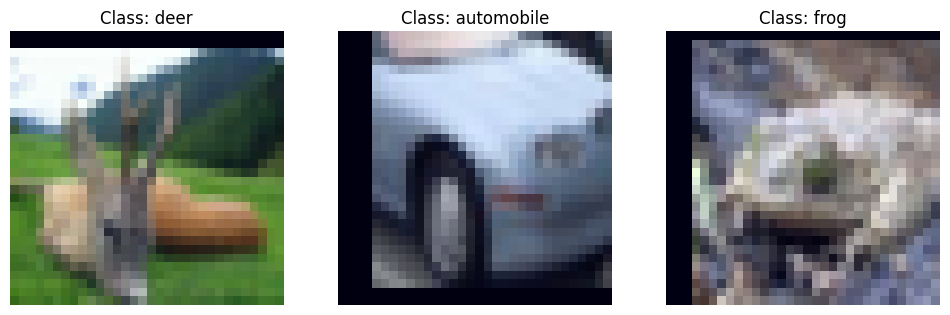

In [9]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get one batch from the train_loader
for images, labels in train_loader:
    break  # Break after the first batch

# Choose three random indices
random_indices = np.random.choice(train_batch_size, 3, replace=False)

# Display the three random images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, index in enumerate(random_indices):
    image = images[index].numpy().transpose((1, 2, 0))
    label = labels[index].item()
    class_name = class_names[label]

    axes[i].imshow(image)
    axes[i].set_title(f"Class: {class_name}")
    axes[i].axis('off')

## 3. Entrenamiento

In [10]:
def initialize_model():

    '''
    Initialize a simple AllConvNet(3) and returns the model and all the
    needed information to train it.
    '''

    global cuda
    model = AllConvNet(3)
    if cuda:
        model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[200, 250, 300], gamma=0.1)

    return_dict = {'model': model, 'optimizer': optimizer,
                  'criterion': criterion, 'scheduler': scheduler}

    return return_dict


def save_plot(path: str, training_data: dict, title: str):

    '''
    Generates a graph of epochs vs accuracies by using the keys and values stored
    in a dictionary. Then, the plot is save into the given drive path.
    '''

    epocas = list(training_data.keys())
    accuracies = list(training_data.values())


    ax = plt.figure(figsize=(12,6))
    plt.plot(epocas, accuracies, label=f'Trained with Normal Images')
    plt.scatter(epocas, accuracies, color='orange')
    plt.grid()
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')

    last_acc, last_ep = accuracies[-1], epocas[-1]
    text_upper_left = f'Last epoch: {last_ep}\nLast acc: {last_acc:.2f}'
    plt.text(0.02, 0.81, text_upper_left, transform=plt.gca().transAxes,
            bbox=dict(facecolor='lightgray', edgecolor='lightgray',
                      boxstyle='round,pad=0.5', alpha=0.5))

    for ep, acc in zip(epocas, accuracies):
        if int(ep) % 40 == 0:
            text = f'Epoch: {ep}\nAcc: {acc:.2f}'
            plt.annotate(text, (ep, acc), textcoords="offset points", xytext=(0,-8),
                         ha='center', va='bottom', bbox=dict(facecolor='lightgray',
                         edgecolor='lightgray', boxstyle='round,pad=0.5', alpha=0.5))

    plt.legend()
    plt.tight_layout()
    plt.savefig(path)

In [11]:
model, optimizer, criterion, scheduler = initialize_model()

In [12]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))


def test(epoch, best_loss, best_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        acc = 100 * correct/len(test_loader.dataset)

    test_loss /= len(test_loader.dataset)
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {} ({:.0f}%)\n'.format(
            test_loss, acc, 100. * correct /
            len(test_loader.dataset)))

    if test_loss < best_loss:
        best_epoch = epoch
        best_loss = test_loss
    return best_loss, best_epoch, acc

Se entrena la red y se guardan los datos cada cierto numero de iteraciones

In [13]:
def checkpoints(current_epoch: int, acc: int, train_dict: dict,
                last_epoch: int, save_every=10):

    if (current_epoch) % save_every == 0 or current_epoch == last_epoch:

        try:
          train_dict[f'{current_epoch}'] = acc.item()

        except AttributeError:
          train_dict[f'{current_epoch}'] = acc

        finally:
          checkpoint = {
              'pretrained_epochs': current_epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'final_accuracy': acc,
              'training_data_dict': train_dict
              }

          std_text = '/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
          checkpoint_path = std_text + f'/allconv_noblur_checkpts/checkpoint_epoch_{current_epoch}.pt'
          torch.save(checkpoint, checkpoint_path)
          print(f'\nCheckpoint saved at epoch {current_epoch}.\n ')
    return train_dict

## 4. Entrenar

In [14]:
# Ojito con ejecutarlo mal y perder avances
training_data_dict = {}

In [15]:
model_stuff = initialize_model()
model = model_stuff['model']
optimizer = model_stuff['optimizer']
criterion = model_stuff['criterion']
scheduler = model_stuff['scheduler']

for epoch in range(0, 361):
    scheduler.step()
    train(epoch)
    best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch)
    training_data_dict = checkpoints(current_epoch=epoch, acc=acc,
                          train_dict=training_data_dict, last_epoch=360,
                                      save_every=10)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Se truncaron las últimas líneas 5000 del resultado de transmisión.

Train Epoch: 102 [0/50000 (0%)]	Loss: 0.914023
Train Epoch: 102 [3200/50000 (6%)]	Loss: 0.665968
Train Epoch: 102 [6400/50000 (13%)]	Loss: 0.760033
Train Epoch: 102 [9600/50000 (19%)]	Loss: 1.284426
Train Epoch: 102 [12800/50000 (26%)]	Loss: 0.835921
Train Epoch: 102 [16000/50000 (32%)]	Loss: 0.651541
Train Epoch: 102 [19200/50000 (38%)]	Loss: 0.443648
Train Epoch: 102 [22400/50000 (45%)]	Loss: 0.650609
Train Epoch: 102 [25600/50000 (51%)]	Loss: 1.083146
Train Epoch: 102 [28800/50000 (58%)]	Loss: 0.999582
Train Epoch: 102 [32000/50000 (64%)]	Loss: 0.747019
Train Epoch: 102 [35200/50000 (70%)]	Loss: 0.596122
Train Epoch: 102 [38400/50000 (77%)]	Loss: 0.615362
Train Epoch: 102 [41600/50000 (83%)]	Loss: 0.643081
Train Epoch: 102 [44800/50000 (90%)]	Loss: 0.903215
Train Epoch: 102 [48000/50000 (96%)]	Loss: 0.942481

Test set: Average loss: 0.0069, Accuracy: 70.05000305175781 (70%)

Train Epoch: 103 [0/50000 (0%)]	Loss: 1.1

In [ ]:
# Añadir algun valor para la epoca 0.

In [ ]:
model, optimizer, criterion, scheduler = initialize_model()
std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos/'
path = std_text + f'/allconv_noblur_checkpts/checkpoint_epoch_240.pt'
model_data = torch.load(path)

model_state_dict = model_data['model_state_dict']
model.load_state_dict(model_state_dict)

optimizer_state_dict = model_data['optimizer_state_dict']
optimizer.load_state_dict(optimizer_state_dict)

pretrained_epochs = model_data['epoch']
training_data_dict = model_data['training_data_dict']
training_data_dict

In [ ]:
# Entrenamos red nomral (sin blur) por 300 épocas y guardamos cada 10. vamos en la 240.
for epoch in range(0, 361):
    scheduler.step()
    train(epoch)
    best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch)
    training_data_dict = checkpoints(current_epoch=epoch, acc=acc,
                          train_dict=training_data_dict, last_epoch=360,
                                      save_every=10)

## 5. Plotting y guardar

In [ ]:
model, optimizer, criterion, scheduler = initialize_model()
std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos/'
path = std_text + f'/allconv_noblur_checkpts/checkpoint_epoch_140.pt'
model_data = torch.load(path)

model_state_dict = model_data['model_state_dict']
model.load_state_dict(model_state_dict)

optimizer_state_dict = model_data['optimizer_state_dict']
optimizer.load_state_dict(optimizer_state_dict)

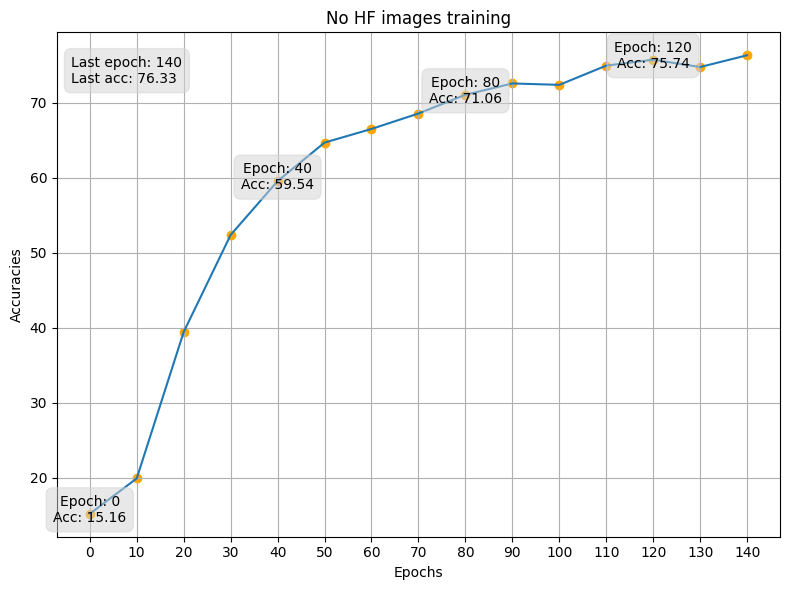

In [ ]:
training_data_dict = model_data['training_data_dict']
path = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos/Graficos/HF training graphs/No_HF_training'
save_plot(path, training_data_dict, 'No HF images training')